In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
! pip3 install -U imutils
! pip install imageio

In [ ]:
import os

import keras
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
import numpy as np
import imageio
import cv2
from IPython.display import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import sys
%matplotlib inline

In [ ]:
# Print environment information to help diagnose issues
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Check for TPU-specific environment variables
tpu_env_vars = {k: v for k, v in os.environ.items() if 'TPU' in k}
if tpu_env_vars:
    print("TPU environment variables found:")
    for k, v in tpu_env_vars.items():
        print(f"  {k}: {v}")
else:
    print("No TPU environment variables found")
    # Try setting TPU name environment variable
    os.environ["TPU_NAME"] = "grpc://10.0.0.1:8470"
    print("Set TPU_NAME to grpc://10.0.0.1:8470")

# Check for available physical devices
physical_devices = tf.config.list_physical_devices()
print("\nPhysical devices:")
for device in physical_devices:
    print(f"  {device.name} ({device.device_type})")

# Try multiple approaches to detect TPU
print("\nAttempting TPU detection:")

# Approach 1: Standard resolver
try:
    print("Approach 1: Standard resolver")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"  TPU detected: {resolver.master()}")
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print(f"  Success: {strategy.num_replicas_in_sync} replicas")
except Exception as e:
    print(f"  Failed: {e}")

    # Approach 2: Local TPU
    try:
        print("\nApproach 2: Local TPU")
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver('local')
        print(f"  TPU detected: {resolver.master()}")
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(f"  Success: {strategy.num_replicas_in_sync} replicas")
    except Exception as e:
        print(f"  Failed: {e}")

        # Approach 3: Experimental TPU Strategy
        try:
            print("\nApproach 3: Experimental TPU Strategy")
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
            print(f"  TPU detected: {resolver.master()}")
            tf.config.experimental_connect_to_cluster(resolver)
            tf.tpu.experimental.initialize_tpu_system(resolver)
            strategy = tf.distribute.experimental.TPUStrategy(resolver)
            print(f"  Success: {strategy.num_replicas_in_sync} replicas")
        except Exception as e:
            print(f"  Failed: {e}")

            # Fallback to default strategy
            print("\nFalling back to default strategy")
            strategy = tf.distribute.get_strategy()

print(f"\nFinal strategy: {strategy.__class__.__name__}")
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

TensorFlow version: 2.18.0
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
TPU environment variables found:
  COLAB_TPU_1VM: 
  TPU_ML_PLATFORM: Tensorflow
  TPU_ML_PLATFORM_VERSION: 2.18.0

Physical devices:
  /physical_device:CPU:0 (CPU)
  /physical_device:GPU:0 (GPU)

Attempting TPU detection:
Approach 1: Standard resolver
  Failed: Please provide a TPU Name to connect to.

Approach 2: Local TPU
  TPU detected: 
  Failed: TPUs not found in the cluster. Failed in initialization: No OpKernel was registered to support Op 'ConfigureDistributedTPU' used by {{node ConfigureDistributedTPU}} with these attrs: [embedding_config="", compilation_failure_closes_chips=false, enable_whole_mesh_compilations=false, is_global_init=false, tpu_embedding_config="", tpu_cancellation_closes_chips=2]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[ConfigureDistributedTPU]] [Op:__inference__tpu_init_fn_6449]

Approach 3: Experimental TPU Strategy
  Faile

# Define hyperparameters

In [ ]:
IMG_SIZE = 224
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


Total videos for training: 594
Total videos for testing: 224


In [ ]:
train_df.head()

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot


In [ ]:
test_df.head()

,video_name,tag
0,v_CricketShot_g01_c01.avi,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot


<ipython-input-25-eec8ef787912>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="tag",data=train_df,palette="gnuplot2")


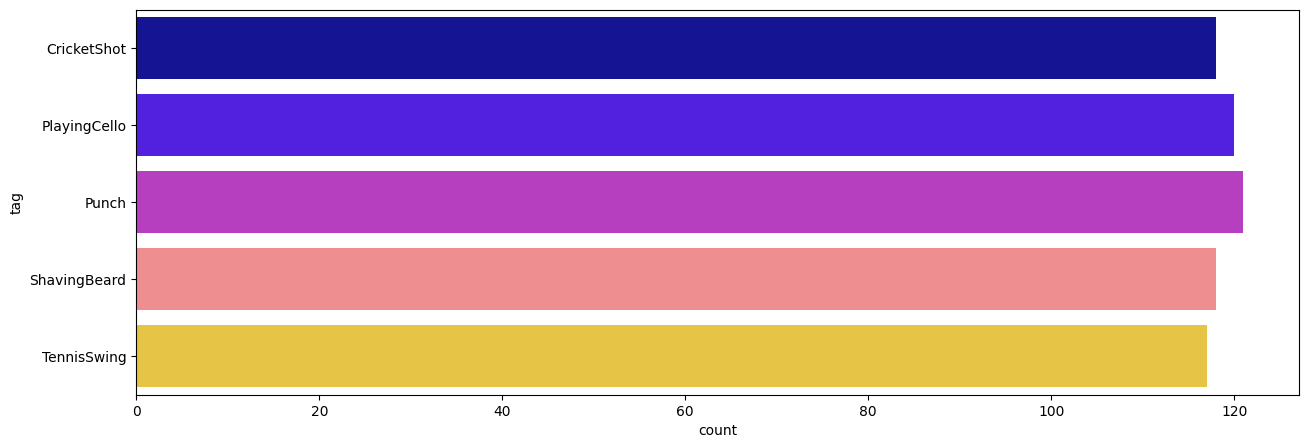

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(y="tag",data=train_df,palette="gnuplot2")
plt.show()

<ipython-input-26-a63d4857275e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="tag",data=test_df,palette="summer")


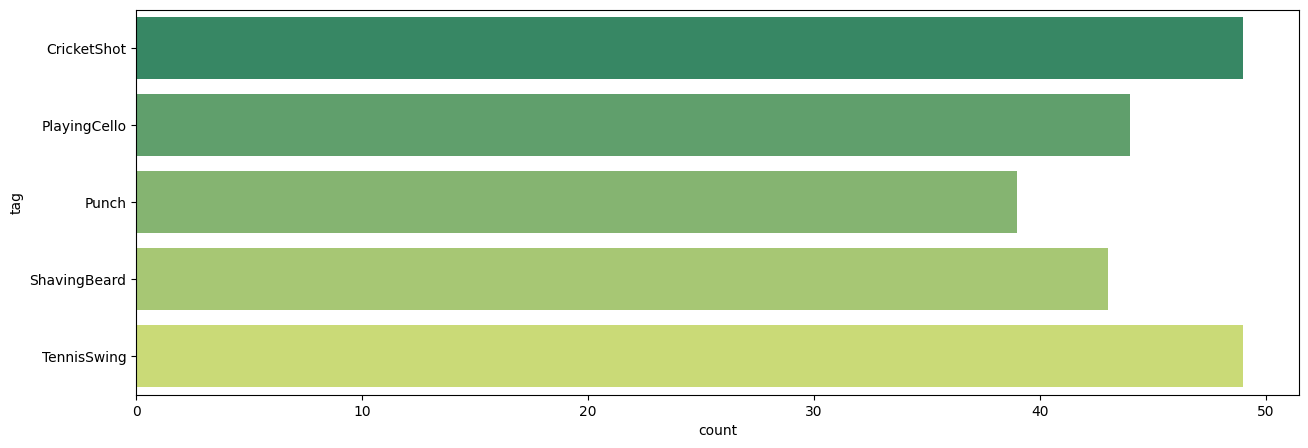

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(y="tag",data=test_df,palette="summer")
plt.show()

* One of the many challenges of training video classifiers is figuring out a way to feed the videos to a network. This blog post discusses five such methods. Since a video is an ordered sequence of frames, we could just extract the frames and put them in a 3D tensor. But the number of frames may differ from video to video which would prevent us from stacking them into batches (unless we use padding). As an alternative, we can save video frames at a fixed interval until a maximum frame count is reached. In this example we will do the following:

* 1.Capture the frames of a video.
* 2.Extract frames from the videos until a maximum frame count is reached.
* 3.In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.

* Note that this workflow is identical to problems involving texts sequences. Videos of the UCF101 dataset is known to not contain extreme variations in objects and actions across frames. Because of this, it may be okay to only consider a few frames for the learning task. But this approach may not generalize well to other video classification problems. We will be using OpenCV's VideoCapture() method to read frames from videos.

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

* We can use a pre-trained network to extract meaningful features from the extracted frames. The Keras Applications module provides a number of state-of-the-art models pre-trained on the ImageNet-1k dataset. We will be using the InceptionV3 model for this purpose.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(weights="imagenet",include_top=False,pooling="avg",input_shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

* The labels of the videos are strings. Neural networks do not understand string values, so they must be converted to some numerical form before they are fed to the model. Here we will use the StringLookup layer encode the class labels as integers.

In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

[np.str_('CricketShot'), np.str_('PlayingCello'), np.str_('Punch'), np.str_('ShavingBeard'), np.str_('TennisSwing')]


# Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
from tqdm import tqdm

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))



    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for idx, path in tqdm(enumerate(video_paths), total=num_samples, desc="Processing Videos"):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
        temp_frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        video_length = frames.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)

        for j in range(length):
            features = feature_extractor.predict(frames[:, j, ...], verbose=0).flatten()

            if features.shape[0] != NUM_FEATURES:
                raise ValueError(f"Feature size mismatch: expected {NUM_FEATURES}, got {features.shape[0]}")

            temp_frame_features[0, j, :] = features

        temp_frame_mask[0, :length] = 1

        frame_features[idx, :, :] = temp_frame_features[0]
        frame_masks[idx, :] = temp_frame_mask[0]

    return (frame_features, frame_masks), labels


# Run with tqdm progress bar
train_data, train_labels = prepare_all_videos(train_df, "/content/train")
test_data, test_labels = prepare_all_videos(test_df, "/content/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")


Processing Videos: 100%|██████████| 224/224 [07:42<00:00,  2.06s/it]

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)
Frame features in test set: (224, 20, 2048)
Frame masks in test set: (224, 20)


# Building the Transformer-based model

We will be building on top of the code shared in
[this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of
[Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python)
by François Chollet.

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [ ]:
from tensorflow import keras

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Increased complexity with more GRU units and layers
    x = keras.layers.GRU(1024, return_sequences=True)(frame_features_input, mask=mask_input)  # First GRU layer
    x = keras.layers.GRU(512, return_sequences=True)(x, mask=mask_input)  # Second GRU layer
    x = keras.layers.GRU(256)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(64, activation="relu")(x)  # Second dense layer
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(loss="sparse_categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=5e-3),metrics=["accuracy"])
    return rnn_model


with strategy.scope():
    model=get_sequence_model()
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 20, 2048)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 20, 1024)       │      9,443,328 │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 20, 512)        │      2,362,368 │ gru[0][0],             │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 256)            │        591,360 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ gru_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 5)              │            325 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,439,045 (47.45 MB)

 Trainable params: 12,438,789 (47.45 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
filepath="/content/model_weights.weights.h5"
checkpoint=keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True,save_best_only=True,verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=30,min_lr=1e-6,verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True,verbose=1)

In [ ]:
EPOCHS = 100
history = model.fit([train_data[0],train_data[1]],train_labels,batch_size=64,validation_data=([test_data[0],test_data[1]],test_labels), epochs=EPOCHS, callbacks=[checkpoint, reduce_lr, early_stopping])


Epoch 1/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4882 - loss: 1.3023
Epoch 1: val_loss improved from inf to 0.71285, saving model to /content/model_weights.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5213 - loss: 1.2138 - val_accuracy: 0.6920 - val_loss: 0.7129 - learning_rate: 0.0050
Epoch 2/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9452 - loss: 0.1579
Epoch 2: val_loss did not improve from 0.71285
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9457 - loss: 0.1572 - val_accuracy: 0.5670 - val_loss: 1.1514 - learning_rate: 0.0050
Epoch 3/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9781 - loss: 0.0673
Epoch 3: val_loss did not improve from 0.71285
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9794 - loss: 0.0655 - val_accuracy: 0.7366 - val_loss: 0.7142 - learning_rate: 0.0050
Epoch 4/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9939 - loss: 0.0261
Epoch 4: val_loss improved from 0.71285 to 

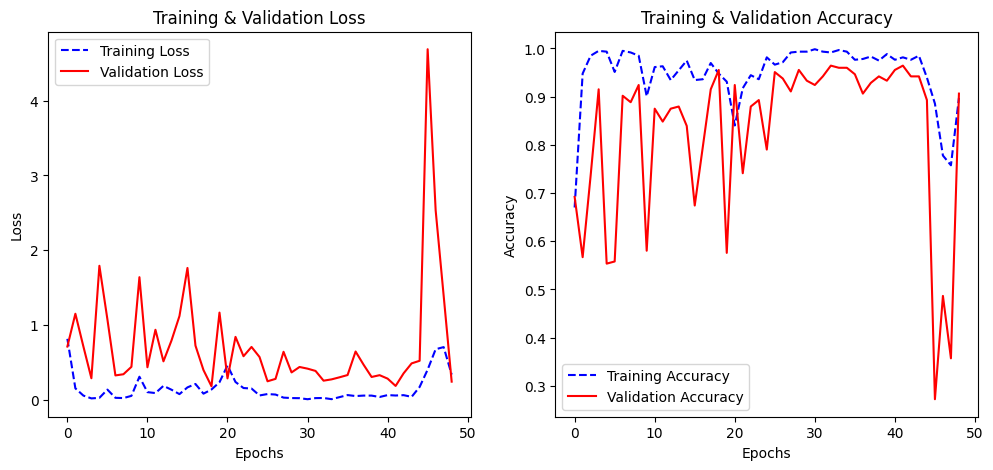

In [ ]:

history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

epochs_range = range(len(loss))

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Training Loss", color='blue', linestyle='dashed')
plt.plot(epochs_range, val_loss, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Training Accuracy", color='blue', linestyle='dashed')
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


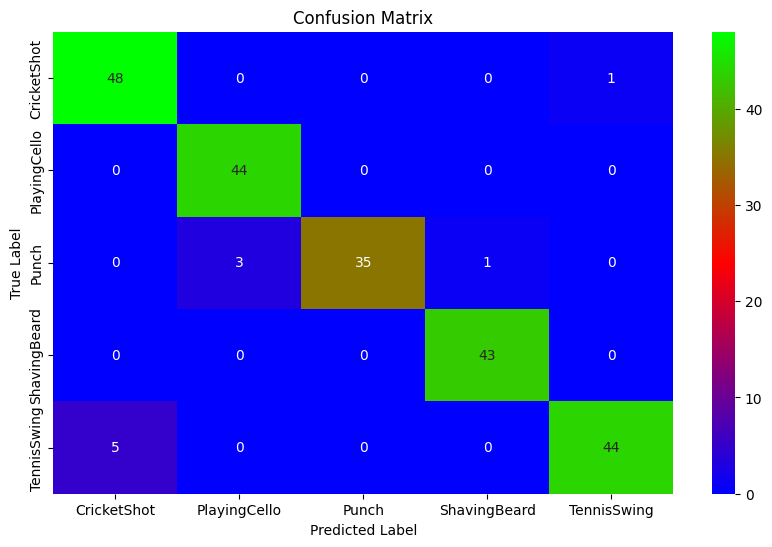

In [ ]:

y_pred_probs = model.predict([test_data[0], test_data[1]])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="brg", xticklabels=label_processor.get_vocabulary(), yticklabels=label_processor.get_vocabulary())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(y_true,y_pred,target_names=label_processor.get_vocabulary()))

              precision    recall  f1-score   support

 CricketShot       0.91      0.98      0.94        49
PlayingCello       0.94      1.00      0.97        44
       Punch       1.00      0.90      0.95        39
ShavingBeard       0.98      1.00      0.99        43
 TennisSwing       0.98      0.90      0.94        49

    accuracy                           0.96       224
   macro avg       0.96      0.95      0.96       224
weighted avg       0.96      0.96      0.96       224



Test video path: v_Punch_g05_c07.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
  Punch: 99.73%
  CricketShot:  0.26%
  PlayingCello:  0.01%
  TennisSwing:  0.00%
  ShavingBeard:  0.00%


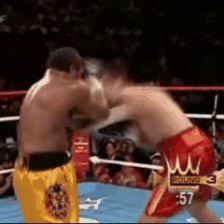

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1,MAX_SEQ_LENGTH,),dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


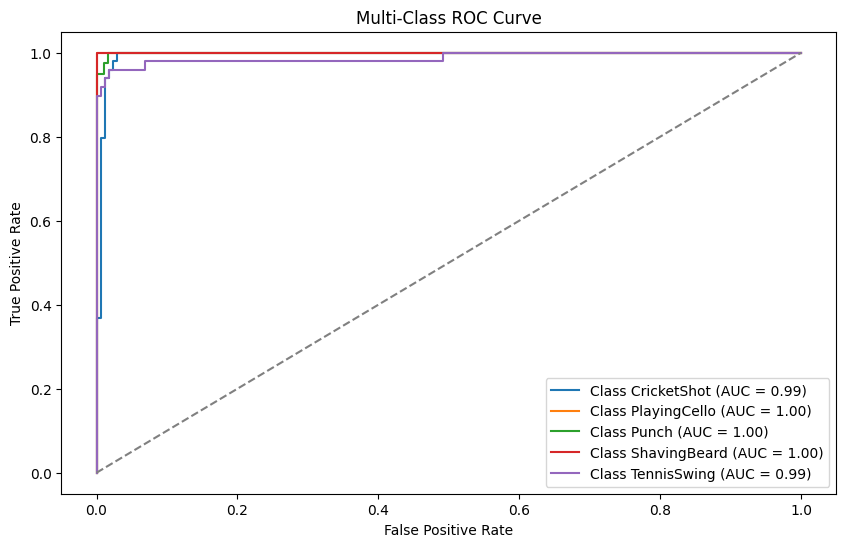

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Get model predictions (probabilities)
y_pred_probs = model.predict([test_data[0], test_data[1]])

# Convert true labels to one-hot encoding
num_classes = len(label_processor.get_vocabulary())
y_true = label_binarize(test_labels, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_processor.get_vocabulary()[i]} (AUC = {roc_auc:.2f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


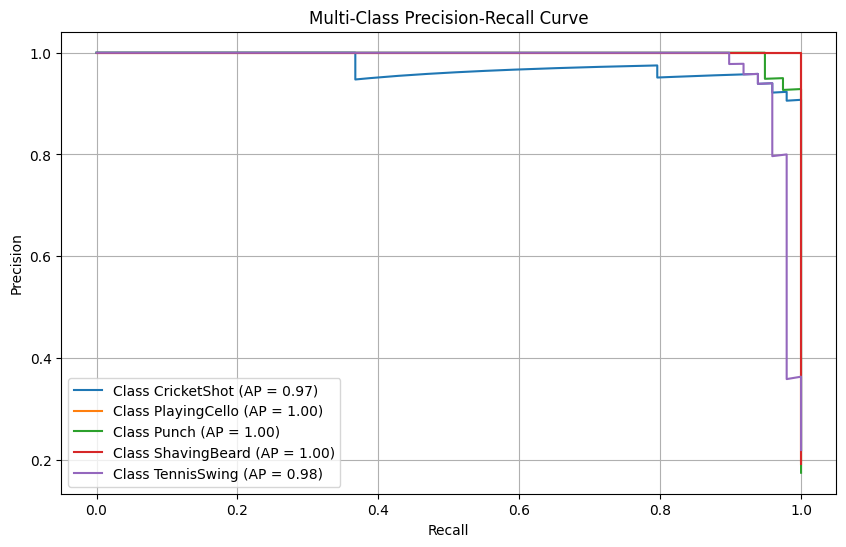

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score


# Get model predictions (probabilities)
y_pred_probs = model.predict([test_data[0], test_data[1]])

# Convert true labels to one-hot encoding
num_classes = len(label_processor.get_vocabulary())
y_true = label_binarize(test_labels, classes=np.arange(num_classes))

# Initialize plot
plt.figure(figsize=(10, 6))

# Compute Precision-Recall curve and Average Precision Score for each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"Class {label_processor.get_vocabulary()[i]} (AP = {avg_precision:.2f})")

# Labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-Class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()

# Show plot
plt.show()
